In [ ]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
import scipy.io
import h5py
import sklearn
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu

In [8]:
import torch
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
import os
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch import Tensor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from itertools import product
from sklearn.model_selection import train_test_split, KFold

# **Age Distribution Analysis**

In [2]:
data_raw = pd.read_csv(r'C:\Users\polig\Desktop\TESI_DRIVE\TESI\data_raw_nmm_new.csv')
strat_covars = pd.read_csv(r'C:\Users\polig\Desktop\TESI_DRIVE\TESI\MatchedData01.csv')


In [3]:
from scipy.stats import mannwhitneyu

age_diagnosis_0 = strat_covars[strat_covars['Dx'] == 0]['Age']
age_diagnosis_1 = strat_covars[strat_covars['Dx'] == 1]['Age']

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')

print(f"U-statistic: {u_stat}, P-value: {p_value}")

U-statistic: 120173.5, P-value: 2.9196695036136526e-09


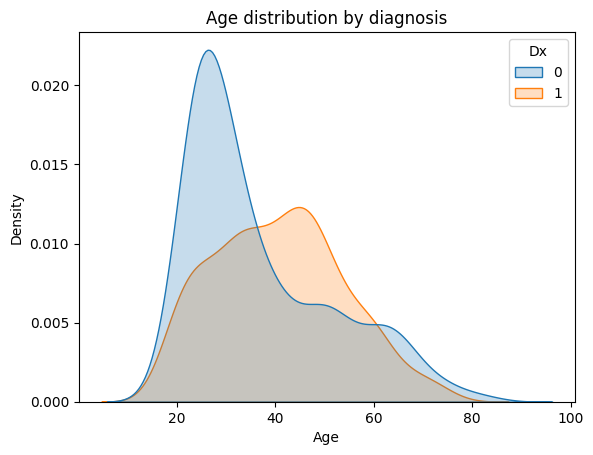

In [4]:
sns.kdeplot(data=strat_covars, x='Age', hue='Dx', fill=True)
plt.title('Age distribution by diagnosis')
plt.show()

In [6]:
for batch in strat_covars['batch'].unique():

    batch_data = strat_covars[strat_covars['batch'] == batch]

    age_diagnosis_0 = batch_data[batch_data['Dx'] == 0]['Age']
    age_diagnosis_1 = batch_data[batch_data['Dx'] == 1]['Age']

    u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')

    print(f"U-statistic: {u_stat}, P-value: {p_value}")

U-statistic: 191.0, P-value: 2.640307615091674e-08
U-statistic: 26025.0, P-value: 0.4547186884848602
U-statistic: 659.5, P-value: 0.0002660905272752914
U-statistic: 71.0, P-value: 0.007739034665149245
U-statistic: 2323.0, P-value: 3.378704092602455e-08
U-statistic: 741.5, P-value: 0.5183619824357639
U-statistic: 779.0, P-value: 0.6743907009213934


### Batch 1

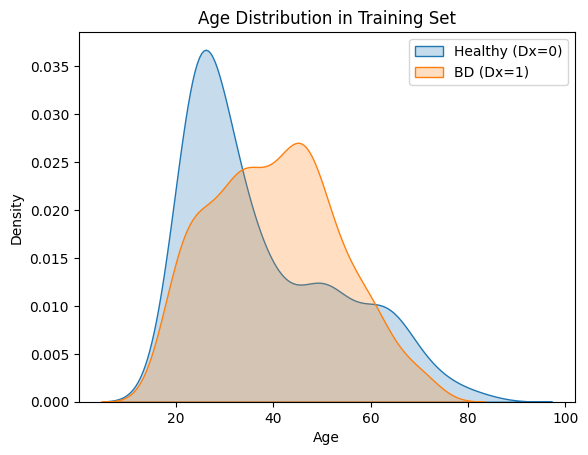

T-statistic: -2.8094290914717375, P-value: 0.005061662383133231
U-statistic: 105068.0, P-value: 6.29375965925409e-05


In [8]:
# Extract the training set covariates
train_covars = strat_covars[strat_covars['batch']!=1]

# Filter by diagnosis
age_diagnosis_0 = train_covars[train_covars['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars[train_covars['Dx'] == 1]['Age']

# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

In [9]:
import numpy as np

# Define drop fractions
drop_fraction_healthy = 0.2
drop_fraction_bd = 0.2

# Identify subjects to drop
healthy_to_drop = train_covars[
    (train_covars['Dx'] == 0) &
    (train_covars['Age'] >= 15) &
    (train_covars['Age'] <= 30)
].sample(frac=drop_fraction_healthy, random_state=42)

bd_to_drop = train_covars[
    (train_covars['Dx'] == 1) &
    (train_covars['Age'] >= 40) &
    (train_covars['Age'] <= 60)
].sample(frac=drop_fraction_bd, random_state=42)


indices_to_remove_1 = set(healthy_to_drop.index).union(set(bd_to_drop.index))

train_covars_new = train_covars.drop(indices_to_remove_1)


print(f"Removed {len(indices_to_remove_1)} subjects ({len(healthy_to_drop)} healthy, {len(bd_to_drop)} bd)")
print(f"New training set size: {len(train_covars_new)}")


Removed 89 subjects (46 healthy, 43 bd)
New training set size: 904


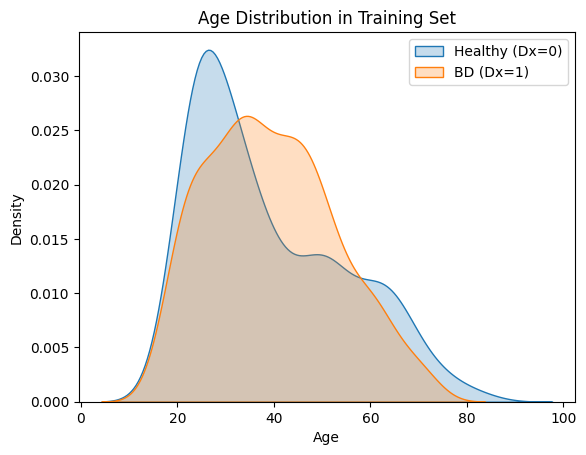

T-statistic: -0.4908795906881528, P-value: 0.6236322541219329
U-statistic: 96033.0, P-value: 0.12479356406854743


In [10]:
age_diagnosis_0 = train_covars_new[train_covars_new['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars_new[train_covars_new['Dx'] == 1]['Age']


# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

### Batch 3

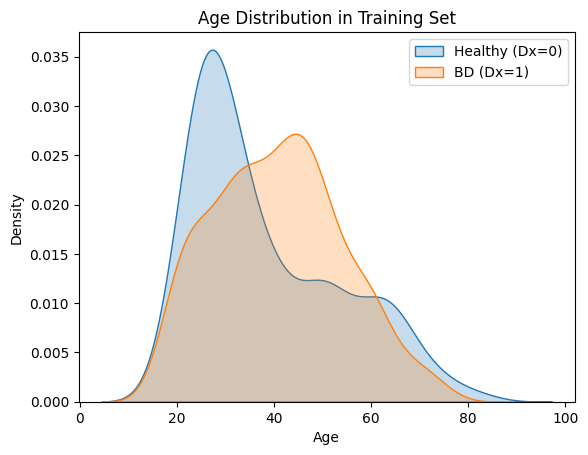

T-statistic: -2.631330338304696, P-value: 0.008641732596203067
U-statistic: 101725.5, P-value: 0.00018746527677721656


In [11]:
# Extract the training set covariates
train_covars = strat_covars[strat_covars['batch']!=3]

# Filter by diagnosis
age_diagnosis_0 = train_covars[train_covars['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars[train_covars['Dx'] == 1]['Age']

# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

In [12]:
import numpy as np

# Define drop fractions
drop_fraction_healthy = 0.2
drop_fraction_bd = 0.2

# Identify subjects to drop
healthy_to_drop = train_covars[
    (train_covars['Dx'] == 0) &
    (train_covars['Age'] >= 15) &
    (train_covars['Age'] <= 30)
].sample(frac=drop_fraction_healthy, random_state=42)

bd_to_drop = train_covars[
    (train_covars['Dx'] == 1) &
    (train_covars['Age'] >= 40) &
    (train_covars['Age'] <= 60)
].sample(frac=drop_fraction_bd, random_state=42)


indices_to_remove_3 = set(healthy_to_drop.index).union(set(bd_to_drop.index))

train_covars_new = train_covars.drop(indices_to_remove_3)


print(f"Removed {len(indices_to_remove_3)} subjects ({len(healthy_to_drop)} healthy, {len(bd_to_drop)} bd)")
print(f"New training set size: {len(train_covars_new)}")


Removed 86 subjects (42 healthy, 44 bd)
New training set size: 886


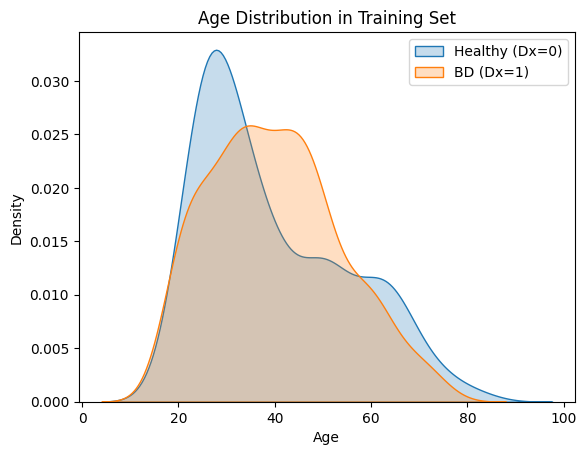

T-statistic: -0.32098181360795763, P-value: 0.7483006763942397
U-statistic: 93316.5, P-value: 0.21049004390778348


In [13]:
age_diagnosis_0 = train_covars_new[train_covars_new['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars_new[train_covars_new['Dx'] == 1]['Age']


# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

### Batch 4

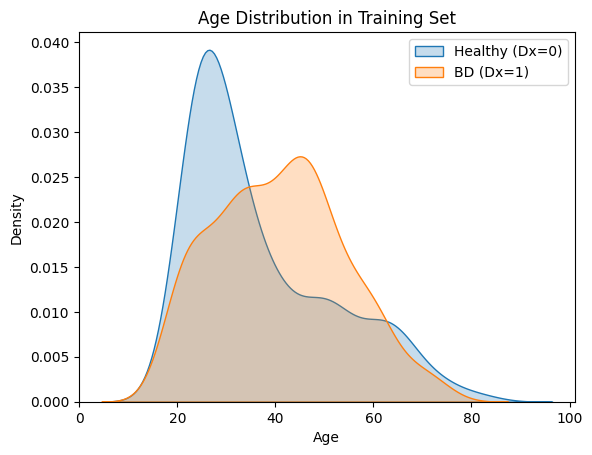

T-statistic: -4.420821282520784, P-value: 1.084194165674405e-05
U-statistic: 113916.0, P-value: 3.647154188255581e-08


In [14]:
# Extract the training set covariates
train_covars = strat_covars[strat_covars['batch']!=4]

# Filter by diagnosis
age_diagnosis_0 = train_covars[train_covars['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars[train_covars['Dx'] == 1]['Age']

# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

In [15]:
import numpy as np

# Define drop fractions
drop_fraction_healthy = 0.3
drop_fraction_bd = 0.3

# Identify subjects to drop
healthy_to_drop = train_covars[
    (train_covars['Dx'] == 0) &
    (train_covars['Age'] >= 15) &
    (train_covars['Age'] <= 30)
].sample(frac=drop_fraction_healthy, random_state=42)

bd_to_drop = train_covars[
    (train_covars['Dx'] == 1) &
    (train_covars['Age'] >= 40) &
    (train_covars['Age'] <= 60)
].sample(frac=drop_fraction_bd, random_state=42)


indices_to_remove_4 = set(healthy_to_drop.index).union(set(bd_to_drop.index))

train_covars_new = train_covars.drop(indices_to_remove_4)


print(f"Removed {len(indices_to_remove_4)} subjects ({len(healthy_to_drop)} healthy, {len(bd_to_drop)} bd)")
print(f"New training set size: {len(train_covars_new)}")


Removed 147 subjects (80 healthy, 67 bd)
New training set size: 921


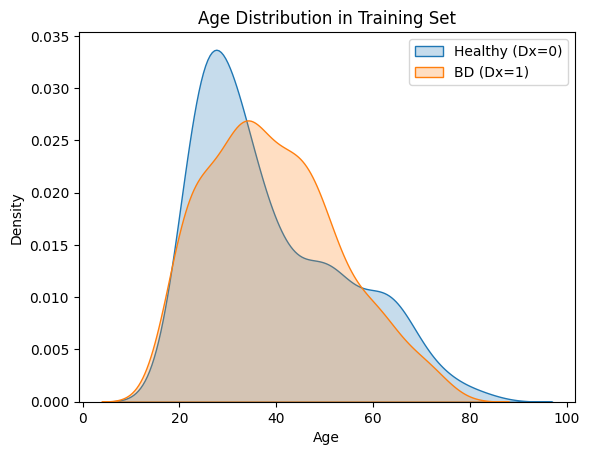

T-statistic: -0.49351195094881384, P-value: 0.6217692732887664
U-statistic: 99826.0, P-value: 0.17432135070713173


In [16]:
age_diagnosis_0 = train_covars_new[train_covars_new['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars_new[train_covars_new['Dx'] == 1]['Age']


# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

### Batch 5

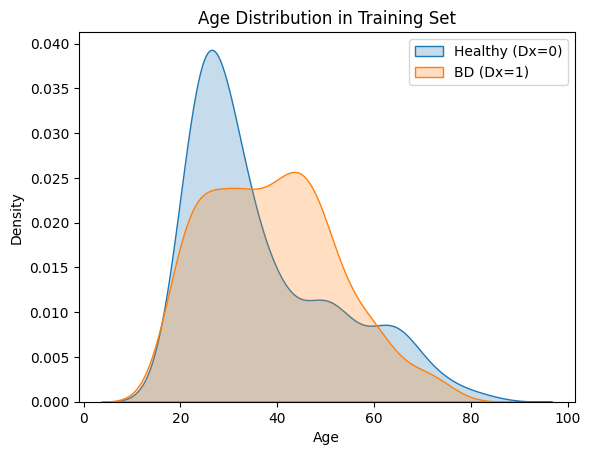

T-statistic: -2.2452814392839615, P-value: 0.025008911649346526
U-statistic: 86537.0, P-value: 0.0012784827038461466


In [17]:
# Extract the training set covariates
train_covars = strat_covars[strat_covars['batch']!=5]

# Filter by diagnosis
age_diagnosis_0 = train_covars[train_covars['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars[train_covars['Dx'] == 1]['Age']

# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

In [18]:
import numpy as np

# Define drop fractions
drop_fraction_healthy = 0.2
drop_fraction_bd = 0.2

# Identify subjects to drop
healthy_to_drop = train_covars[
    (train_covars['Dx'] == 0) &
    (train_covars['Age'] >= 15) &
    (train_covars['Age'] <= 30)
].sample(frac=drop_fraction_healthy, random_state=42)

bd_to_drop = train_covars[
    (train_covars['Dx'] == 1) &
    (train_covars['Age'] >= 40) &
    (train_covars['Age'] <= 60)
].sample(frac=drop_fraction_bd, random_state=42)


indices_to_remove_5 = set(healthy_to_drop.index).union(set(bd_to_drop.index))

train_covars_new = train_covars.drop(indices_to_remove_5)


print(f"Removed {len(indices_to_remove_5)} subjects ({len(healthy_to_drop)} healthy, {len(bd_to_drop)} bd)")
print(f"New training set size: {len(train_covars_new)}")


Removed 81 subjects (51 healthy, 30 bd)
New training set size: 825


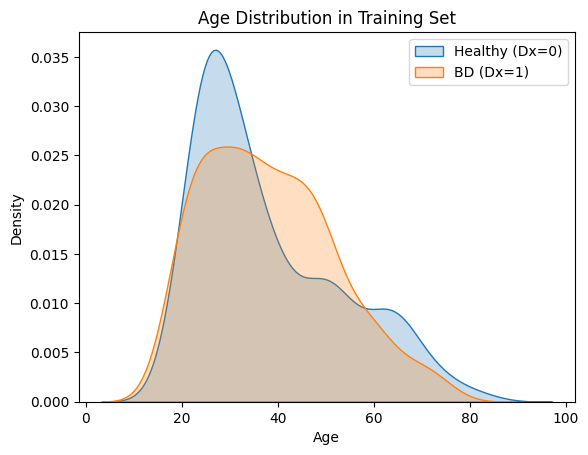

T-statistic: -0.13203451213374962, P-value: 0.8949914416186646
U-statistic: 79291.5, P-value: 0.37087688583147715


In [19]:
age_diagnosis_0 = train_covars_new[train_covars_new['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars_new[train_covars_new['Dx'] == 1]['Age']


# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

### Batch 6

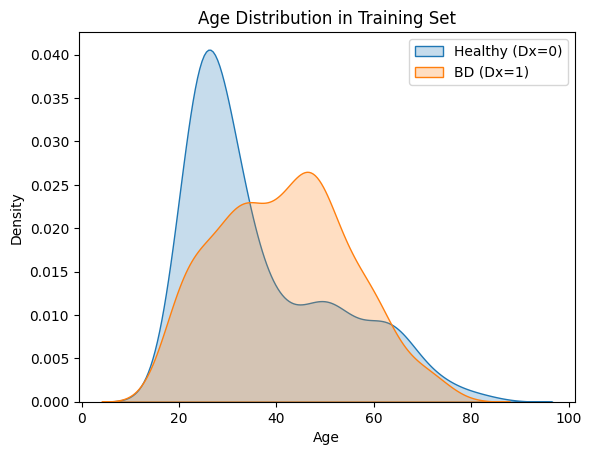

T-statistic: -5.252262666426903, P-value: 1.8377865458695588e-07
U-statistic: 98821.0, P-value: 5.062088918083788e-10


In [20]:
# Extract the training set covariates
train_covars = strat_covars[strat_covars['batch']!=6]

# Filter by diagnosis
age_diagnosis_0 = train_covars[train_covars['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars[train_covars['Dx'] == 1]['Age']

# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

In [21]:
import numpy as np

# Define drop fractions
drop_fraction_healthy = 0.4
drop_fraction_bd = 0.3

# Identify subjects to drop
healthy_to_drop = train_covars[
    (train_covars['Dx'] == 0) &
    (train_covars['Age'] >= 15) &
    (train_covars['Age'] <= 30)
].sample(frac=drop_fraction_healthy, random_state=42)

bd_to_drop = train_covars[
    (train_covars['Dx'] == 1) &
    (train_covars['Age'] >= 40) &
    (train_covars['Age'] <= 60)
].sample(frac=drop_fraction_bd, random_state=42)


indices_to_remove_6 = set(healthy_to_drop.index).union(set(bd_to_drop.index))

train_covars_new = train_covars.drop(indices_to_remove_6)


print(f"Removed {len(indices_to_remove_6)} subjects ({len(healthy_to_drop)} healthy, {len(bd_to_drop)} bd)")
print(f"New training set size: {len(train_covars_new)}")


Removed 174 subjects (112 healthy, 62 bd)
New training set size: 846


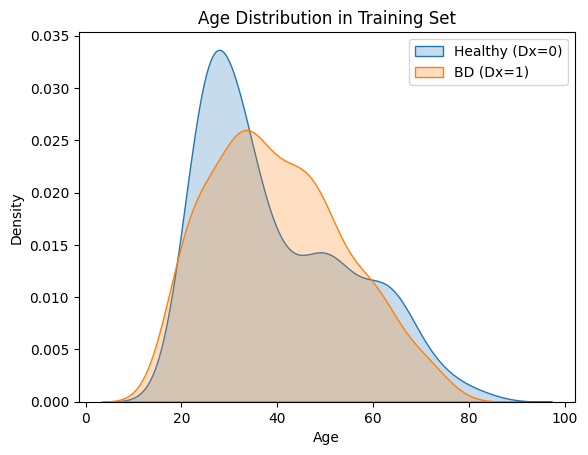

T-statistic: -0.39827911594710264, P-value: 0.6905264161728897
U-statistic: 84629.0, P-value: 0.2634853946843958


In [22]:
age_diagnosis_0 = train_covars_new[train_covars_new['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars_new[train_covars_new['Dx'] == 1]['Age']


# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

### Batch 7

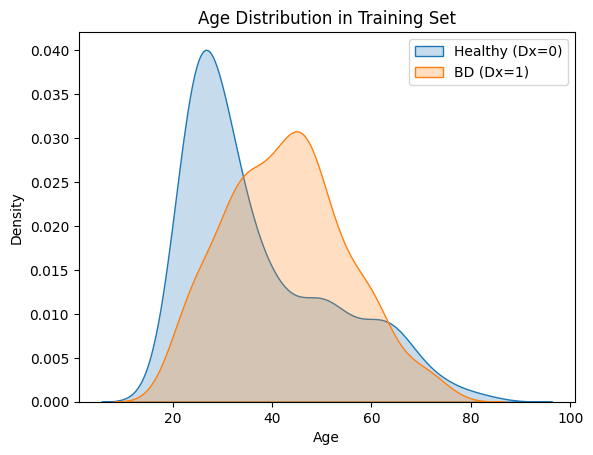

T-statistic: -6.480731907566817, P-value: 1.4217894875262187e-10
U-statistic: 91557.5, P-value: 4.2122376960542176e-15


In [23]:
# Extract the training set covariates
train_covars = strat_covars[strat_covars['batch']!=7]

# Filter by diagnosis
age_diagnosis_0 = train_covars[train_covars['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars[train_covars['Dx'] == 1]['Age']

# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

In [24]:
import numpy as np

# Define drop fractions
drop_fraction_healthy = 0.5
drop_fraction_bd = 0.4

# Identify subjects to drop
healthy_to_drop = train_covars[
    (train_covars['Dx'] == 0) &
    (train_covars['Age'] >= 15) &
    (train_covars['Age'] <= 30)
].sample(frac=drop_fraction_healthy, random_state=42)

bd_to_drop = train_covars[
    (train_covars['Dx'] == 1) &
    (train_covars['Age'] >= 40) &
    (train_covars['Age'] <= 60)
].sample(frac=drop_fraction_bd, random_state=42)


indices_to_remove_7 = set(healthy_to_drop.index).union(set(bd_to_drop.index))

train_covars_new = train_covars.drop(indices_to_remove_7)


print(f"Removed {len(indices_to_remove_7)} subjects ({len(healthy_to_drop)} healthy, {len(bd_to_drop)} bd)")
print(f"New training set size: {len(train_covars_new)}")


Removed 221 subjects (130 healthy, 91 bd)
New training set size: 800


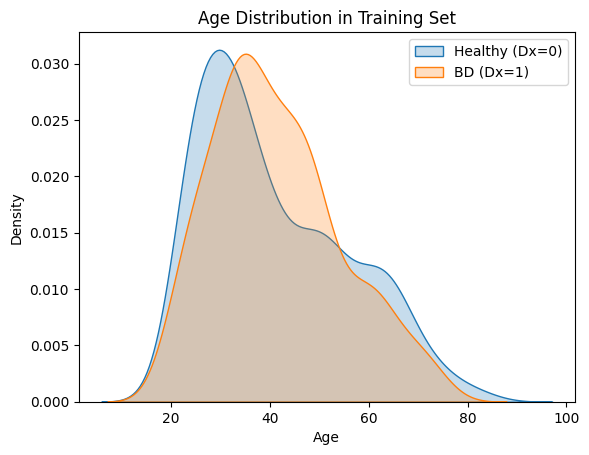

T-statistic: -0.2694013965372869, P-value: 0.7876909244728054
U-statistic: 74983.0, P-value: 0.21741215810311432


In [25]:
age_diagnosis_0 = train_covars_new[train_covars_new['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars_new[train_covars_new['Dx'] == 1]['Age']


# Create the plot
sns.kdeplot(age_diagnosis_0, label='Healthy (Dx=0)', fill=True)
sns.kdeplot(age_diagnosis_1, label='BD (Dx=1)', fill=True)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

# Dataset and model

In [ ]:
# Dataset for Diagnosis Prediction
class MindDataset(InMemoryDataset):
    def __init__(self, root, matrices_harm, strat_covars, adjacency_matrices, roi_data, transform=None, pre_transform=None):
        self.matrices_harm = matrices_harm
        self.strat_covars = strat_covars
        self.adjacency_matrices = adjacency_matrices
        self.roi_data = roi_data
        super().__init__(root, transform, pre_transform)


        self.data, self.slices = torch.load(self.processed_paths[0], weights_only = False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []

        for i in range(len(self.matrices_harm)):
            # Node features: all elements in a row
            node_features = torch.tensor(self.matrices_harm[i], dtype=torch.float)
            roi_features = torch.tensor(self.roi_data.iloc[i].values, dtype=torch.float).unsqueeze(1)

            gender = self.strat_covars['Gender'].iloc[i]
            age = self.strat_covars['Age'].iloc[i]
            age_gender_features = torch.tensor([[gender, age]] * self.matrices_harm[i].shape[0], dtype=torch.float)
            node_features = torch.cat([node_features, age_gender_features, roi_features], dim=1)

            edge_index = torch.tensor(np.array(np.where(self.adjacency_matrices[i] == 1)), dtype=torch.long)

            edge_attr = []
            for j in range(edge_index.shape[1]):
                edge_attr.append(torch.tensor(self.matrices_harm[i][edge_index[0, j], edge_index[1, j]], dtype=torch.float))
            edge_attr = torch.stack(edge_attr).unsqueeze(1)

            # data = Data(x=node_features, edge_index=edge_index, y=torch.tensor(self.strat_covars['Dx'].iloc[i], dtype=torch.long))
            data = Data(x=node_features, edge_index=edge_index, edge_attr = edge_attr, y=torch.tensor(self.strat_covars['Dx'].iloc[i], dtype=torch.long)) 
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def len(self):
        return super().len()

    def get(self, idx):
        return super().get(idx)

In [32]:
import torch.nn as nn

class NodeNorm(nn.Module):
    def __init__(self, nn_type="n", unbiased=False, eps=1e-5, power_root=2):
        super(NodeNorm, self).__init__()
        self.unbiased = unbiased
        self.eps = eps
        self.nn_type = nn_type
        self.power = 1 / power_root

    def forward(self, x):
        if self.nn_type == "n":
            mean = torch.mean(x, dim=1, keepdim=True)
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = (x - mean) / std
        elif self.nn_type == "v":
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / std
        elif self.nn_type == "m":
            mean = torch.mean(x, dim=1, keepdim=True)
            x = x - mean
        elif self.nn_type == "srv":  # square root of variance
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / torch.sqrt(std)
        elif self.nn_type == "pr":
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / torch.pow(std, self.power)
        return x

    def __repr__(self):
        original_str = super().__repr__()
        components = list(original_str)
        nn_type_str = f"nn_type={self.nn_type}"
        components.insert(-1, nn_type_str)
        new_str = "".join(components)
        return new_str

def get_normalization(norm_type, num_channels=None):
    if norm_type is None:
        norm = None
    elif norm_type == "batch":
        norm = nn.BatchNorm1d(num_features=num_channels)
    elif norm_type == "node_n":
        norm = NodeNorm(nn_type="n")
    elif norm_type == "node_v":
        norm = NodeNorm(nn_type="v")
    elif norm_type == "node_m":
        norm = NodeNorm(nn_type="m")
    elif norm_type == "node_srv":
        norm = NodeNorm(nn_type="srv")
    elif norm_type.find("node_pr") != -1:
        power_root = norm_type.split("_")[-1]
        power_root = int(power_root)
        norm = NodeNorm(nn_type="pr", power_root=power_root)
    elif norm_type == "layer":
        norm = nn.LayerNorm(normalized_shape=num_channels)
    else:
        raise NotImplementedError
    return norm


In [33]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, norm_type="node_n"):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))

        self.fc = Linear(hidden_dim, output_dim)
        # self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):

        for conv, bn in zip(self.convs, self.bns):
            x = F.relu(conv(x, edge_index))
            x = bn(x)
            # x = self.dropout(x)

        x = global_mean_pool(x, batch)

        x = self.fc(x)
        return x

In [34]:
import Confounder_Correction_Classes
from Confounder_Correction_Classes import ComBatHarmonization

In [35]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train():
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.append(out.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds)
    train_loss = epoch_loss / len(train_loader)

    return accuracy, train_loss, f1

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            total_loss += loss.item()
            all_preds.append(out.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Calculate metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, zero_division=1.0)
    val_loss = total_loss / len(loader)

    return accuracy, val_loss, f1, all_labels, all_preds

In [ ]:
def split_data(data, strat_covars, roi_data, indices_1, indices_2):

    data_1 = data.drop(indices_2).reset_index(drop=True)
    strat_covars_1 = strat_covars.drop(indices_2).reset_index(drop=True)
    roi_1 = roi_data.drop(indices_2).reset_index(drop=True)

    data_2 = data.drop(indices_1).reset_index(drop=True)
    strat_covars_2 = strat_covars.drop(indices_1).reset_index(drop=True)
    roi_2 = roi_data.drop(indices_1).reset_index(drop=True)

    return data_1, strat_covars_1, roi_1, data_2, strat_covars_2, roi_2

def reconstruct_and_create_adjacency(data_harm, threshold_percentile=70):
    n_matrices, upper_triangle_size = data_harm.shape
    N = int((1 + np.sqrt(1 + 8 * upper_triangle_size)) // 2)
    matrices = np.zeros((n_matrices, N, N))
    adjacency_matrices = np.zeros((n_matrices, N, N), dtype=int)

    for i in range(n_matrices):
        matrix = np.eye(N)
        upper_indices = np.triu_indices(N, k=1)
        matrix[upper_indices] = data_harm.iloc[i]
        matrix = matrix + matrix.T
        np.fill_diagonal(matrix, 1)
        matrices[i] = matrix

        threshold = np.percentile(matrix, threshold_percentile)
        adjacency_matrices[i] = (matrix >= threshold).astype(int)

    return matrices, adjacency_matrices

def harmonize_data_2(data_1_raw, strat_covars_1, data_2_raw, strat_covars_2, ext_batch):
    volumes_columns = np.arange(0, data_1_raw.shape[1])

    feat_detail={'volumes':           {'id': volumes_columns,
                                            'categorical': ['Gender'],
                                            'continuous':['Age']}}

    combat_function=ComBatHarmonization(cv_method=None, ref_batch=None,
                                           regression_fit=0,
                                           feat_detail=feat_detail,
                                           feat_of_no_interest=None)

    data_1_dict={'data': data_1_raw, 'covariates': strat_covars_1}
    data_1_harm = combat_function.fit_transform(data_1_dict)
    data_1_harm = pd.DataFrame(data_1_harm)

    #Harmonize the test set
    data_2_raw = pd.DataFrame(data_2_raw)
    data_2_raw.columns = data_2_raw.columns.astype(int)
    data_2_raw.index = pd.RangeIndex(start=0, stop=len(data_2_raw), step=1)
    all_data = pd.concat([data_1_harm, data_2_raw], ignore_index=True)
    all_strat_covars = pd.concat([strat_covars_1, strat_covars_2], ignore_index=True)
    all_strat_covars.loc[all_strat_covars["batch"] != ext_batch, "batch"] = 0
    
    test_combat_function=ComBatHarmonization(cv_method=None, ref_batch=0,
                                           regression_fit=0,
                                           feat_detail=feat_detail,
                                           feat_of_no_interest=None)

    all_data_dict={'data': all_data, 'covariates': all_strat_covars}
    all_data_harm = test_combat_function.fit_transform(all_data_dict)
    all_data_harm = pd.DataFrame(all_data_harm)

    data_2_harm = all_data_harm.drop(data_1_harm.index)
    data_2_harm = data_2_harm.reset_index(drop=True)
    data_2_harm = pd.DataFrame(data_2_harm)

    return data_1_harm, data_2_harm

def harmonize_data(train_data_raw, train_strat_covars, test_data_raw, test_strat_covars):

            volumes_columns = np.arange(0, train_data_raw.shape[1])

            feat_detail={'volumes':           {'id': volumes_columns,
                                            'categorical': ['Gender'],
                                            'continuous':['Age']}}

            combat_function=ComBatHarmonization(cv_method=None, ref_batch=None,
                                              regression_fit=0,
                                              feat_detail=feat_detail,
                                              feat_of_no_interest=None)

            train_data_dict={'data': train_data_raw, 'covariates': train_strat_covars}
            train_data_harm = combat_function.fit_transform(train_data_dict)
            train_data_harm = pd.DataFrame(train_data_harm)

            test_data_dict={'data': test_data_raw, 'covariates': test_strat_covars}
            test_data_harm = combat_function.transform(test_data_dict)
            test_data_harm = pd.DataFrame(test_data_harm)

            return train_data_harm, test_data_harm


# Edge Weight

In [63]:

from torch.nn import BatchNorm1d, Dropout

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, norm_type="node_n"):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))

        self.fc = Linear(hidden_dim, output_dim)
        # self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, edge_attr, batch):

        for conv, bn in zip(self.convs, self.bns):
            x = F.relu(conv(x, edge_index, edge_attr))
            x = bn(x)
            # x = self.dropout(x)

        x = global_mean_pool(x, batch)

        x = self.fc(x)
        return x
    
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train():
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.append(out.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    train_loss = epoch_loss / len(train_loader)

    return accuracy, train_loss, f1

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = F.cross_entropy(out, data.y)
            total_loss += loss.item()
            all_preds.append(out.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Calculate metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    val_loss = total_loss / len(loader)

    return accuracy, val_loss, f1, all_preds, all_labels

# K-Fold cross validation

In [ ]:
ext_test_batches = [1, 3, 4, 5, 6, 7]
indices_to_remove = [indices_to_remove_1, indices_to_remove_3, indices_to_remove_4, indices_to_remove_5, indices_to_remove_6, indices_to_remove_7] #
final_results = []

for ext_test_batch, indices in zip(ext_test_batches, indices_to_remove):
    print(f"Test batch: {ext_test_batch}")

    data_raw = pd.read_csv('data_raw_nmm_new.csv')
    strat_covars = pd.read_csv('MatchedData01.csv')
    roi_raw = pd.read_csv('roi_data_raw_nmm_norm.csv')

    data_raw = data_raw.drop(indices)
    strat_covars = strat_covars.drop(indices)
    roi_raw = roi_raw.drop(indices)

    #SEPARATE CROSS VALIDATION DATA AND EXTERNAL TEST SET DATA
    ext_test_indices = strat_covars[strat_covars['batch'] == ext_test_batch].index
    cv_indices = strat_covars[strat_covars["batch"] != ext_test_batch].index

    cv_data_raw, cv_strat_covars, cv_roi_raw, ext_test_data_raw, ext_test_strat_covars, ext_test_roi_raw = split_data(data_raw, strat_covars, roi_raw, cv_indices, ext_test_indices)

    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    results = []

    #CROSS VALIDATION

    for fold, (train_indices, test_indices) in enumerate(kf.split(cv_data_raw)):
        print(f"\nFold: {fold+1}/{k_folds}")

        #SEPARATE TRAIN AND TEST DATA

        train_data_raw, train_strat_covars, train_roi_raw, test_data_raw, test_strat_covars, test_roi_raw = split_data(cv_data_raw, cv_strat_covars, cv_roi_raw, train_indices, test_indices)

        # HARMONIZE DATA
        train_data_harm, test_data_harm = harmonize_data(train_data_raw, train_strat_covars, test_data_raw, test_strat_covars)
        train_roi_harm, test_roi_harm = harmonize_data(train_roi_raw, train_strat_covars, test_roi_raw, test_strat_covars)

        print("Data harmonized")

        # RECONSTRUCT MATRICES AND CREATE ADJACENCY MATRICES

        train_matrices_harm, train_adjacency_matrices = reconstruct_and_create_adjacency(train_data_harm)
        test_matrices_harm, test_adjacency_matrices = reconstruct_and_create_adjacency(test_data_harm)

        print("Matrices created")

        # CREATE DATASETS

        train_dataset_path = f"Datasets/CV/NMM70/MindDatasetTrainNMM70_{ext_test_batch}_fold{fold+1}"
        test_dataset_path = f"Datasets/CV/NMM70/MindDatasetValNMM70_{ext_test_batch}_fold{fold+1}"

        train_dataset = MindDataset(
            root=train_dataset_path,
            matrices_harm=train_matrices_harm,
            strat_covars=train_strat_covars,
            adjacency_matrices=train_adjacency_matrices,
            roi_data=train_roi_harm
        )

        test_dataset = MindDataset(
            root=test_dataset_path,
            matrices_harm=test_matrices_harm,
            strat_covars=test_strat_covars,
            adjacency_matrices=test_adjacency_matrices,
            roi_data=test_roi_harm
        )

        #TRAIN AND TEST DIFFERENT PARAMETERS

        layer_dim_pairs = [(2, 32), (2,64),(2,128)]
        norm_types_list = ["node_n", "node_m", "node_srv", "node_pr_2"]
        batch_size = [16, 32]
        param_grid = [(nl, hd, norm, bat) for (nl, hd) in layer_dim_pairs for norm in norm_types_list for bat in batch_size]

        best_val_acc = 0
        best_params = None
        best_model_path = "best_grid_model_1.pt"

        for num_layers, hidden_dim, norm_type, batch_size in param_grid:
            print(f"\nTraining with num_layers={num_layers}, hidden_dim={hidden_dim}, norm_type={norm_type}, batch_size={batch_size}")

            train_indices, val_indices = train_test_split(range(len(train_dataset)), test_size=0.3, random_state=3)
            train_loader = DataLoader(train_dataset[train_indices], batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(train_dataset[val_indices], batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            set_seed(42)

            model = GCN(train_dataset.num_features, hidden_dim=hidden_dim, output_dim=train_dataset.num_classes, num_layers=num_layers, norm_type=norm_type)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            patience = 20
            best_val_loss = float("inf")
            patience_counter = 0

            for epoch in range(100):
                train_acc, train_loss, train_f1 = train()
                val_acc, val_loss, val_f1, _, _ = evaluate(val_loader)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), "temp_model_1.pt")  # Save the best model for this config
                    print(f"Saved best model at epoch {epoch} with  Train Accuracy: {train_acc:.4f}, Val Accuracy {val_acc:.4f}, Val Loss: {val_loss:.4f}")
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

            # Load best model for this configuration
            model.load_state_dict(torch.load("temp_model_1.pt"))
            test_acc, test_loss, test_f1,_,_ = evaluate(test_loader)

            print(f"For num_layers={num_layers}, hidden_dim={hidden_dim}, norm_type={norm_type}, batch:size={batch_size}: Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

            # Store results
            results.append({
                "fold": fold + 1,
                "num_layers": num_layers,
                "hidden_dim": hidden_dim,
                "norm_type": norm_type,
                "batch_size": batch_size,
                "test_accuracy": test_acc,
                "test_loss": test_loss,
                "test_f1": test_f1
            })

    df_results = pd.DataFrame(results)

    df_mean_results = df_results.groupby(["num_layers", "hidden_dim", "norm_type", "batch_size"]).agg(
    {"test_accuracy": "mean", "test_loss": "mean", "test_f1": "mean"}).reset_index()

     # Find the row with the highest mean test accuracy
    best_row = df_mean_results.loc[df_mean_results["test_accuracy"].idxmax()]

    # Extract the best parameters
    best_num_layers = int(best_row["num_layers"])
    best_hidden_dim = int(best_row["hidden_dim"])
    best_norm_type = best_row["norm_type"]
    best_batch_size = int(best_row["batch_size"])

    print(f"Best parameters: num_layers={best_num_layers}, hidden_dim={best_hidden_dim}, norm_type={best_norm_type}, batch_size={best_batch_size}")

    cv_data_harm, ext_test_data_harm = harmonize_data_2(cv_data_raw, cv_strat_covars, ext_test_data_raw, ext_test_strat_covars, ext_test_batch)
    cv_roi_harm, ext_test_roi_harm = harmonize_data_2(cv_roi_raw, cv_strat_covars, ext_test_roi_raw, ext_test_strat_covars, ext_test_batch)

    ext_test_matrices_harm, ext_test_adjacency_matrices = reconstruct_and_create_adjacency(ext_test_data_harm)

    ext_test_dataset_path = f"Datasets/CV/NMM70/MindDatasetExtTestNMM70_batch{ext_test_batch}"
    ext_test_dataset = MindDataset(
        root=ext_test_dataset_path,
        matrices_harm=ext_test_matrices_harm,
        strat_covars=ext_test_strat_covars,
        adjacency_matrices=ext_test_adjacency_matrices,
        roi_data=ext_test_roi_harm
    )

    cv_matrices_harm, cv_adjacency_matrices = reconstruct_and_create_adjacency(cv_data_harm)
    cv_dataset_path = f"Datasets/CV/NMM70/MindDatasetCVNMM70_batch{ext_test_batch}"
    cv_dataset = MindDataset(
        root=cv_dataset_path,
        matrices_harm=cv_matrices_harm,
        strat_covars=cv_strat_covars,
        adjacency_matrices=cv_adjacency_matrices,
        roi_data=cv_roi_harm
    )
    train_indices, val_indices = train_test_split(range(len(cv_dataset)), test_size=0.3, random_state=3)
    train_loader = DataLoader(cv_dataset[train_indices], batch_size=best_batch_size, shuffle=True)
    val_loader = DataLoader(cv_dataset[val_indices], batch_size=best_batch_size, shuffle=False)
    test_loader = DataLoader(ext_test_dataset, batch_size=best_batch_size, shuffle=False)

    set_seed(42)

    model = GCN(cv_dataset.num_features, hidden_dim=best_hidden_dim, output_dim=cv_dataset.num_classes, num_layers=best_num_layers, norm_type=best_norm_type)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    patience = 20
    best_val_loss = float("inf")
    best_val_f1 = 0
    patience_counter = 0

    for epoch in range(100):

        train_acc, train_loss, train_f1 = train()
        val_acc, val_loss, val_f1, _, _ = evaluate(val_loader)  # Validation set metrics
        print(
            f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_1.pt")
            print(f"Saved best model at epoch {epoch} with Val Loss: {val_loss:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} as validation loss did not improve for {patience} consecutive epochs.")
            break


    # Evaluate on test set after training is complete
    model.load_state_dict(torch.load("best_model_1.pt"))
    test_acc, test_loss, test_f1, all_labels, all_preds = evaluate(test_loader)

    test_prec = precision_score(all_labels, all_preds, zero_division=1.0)
    test_recall = recall_score(all_labels, all_preds, zero_division=1.0)

    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

    final_results.append({
                "batch": ext_test_batch,
                "num_layers": best_num_layers,
                "hidden_dim": best_hidden_dim,
                "norm_type": best_norm_type,
                "batch_size": best_batch_size,
                "accuracy": test_acc*100,
                "loss": test_loss,
                "f1": test_f1*100,
                "precision": test_prec*100,
                "recall": test_recall*100,
                "true_negative": tn,
                "false_positive": fp,
                "false_negative": fn,
                "true_positive": tp
            })

    print(f"External test {ext_test_batch} Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}, Precision:{test_prec:.4f}, Recall:{test_recall:.4f}, True Negative {tn}, False Positive {fp}, False Negative {fn}, True Positive {tp}")

df_final_results = pd.DataFrame(final_results)
df_final_results.to_csv('cv_final_results.csv', index=False)